Training model with Legendre polynomial degree 1...
Degree 1 completed. Train Error: 0.533386, Test Error: 0.504435

Training model with Legendre polynomial degree 2...
Degree 2 completed. Train Error: 0.521486, Test Error: 0.509678

Training model with Legendre polynomial degree 3...
Degree 3 completed. Train Error: 0.521485, Test Error: 0.509678

Training model with Legendre polynomial degree 4...
Degree 4 completed. Train Error: 0.498260, Test Error: 0.506884

Training model with Legendre polynomial degree 5...
Degree 5 completed. Train Error: 0.498260, Test Error: 0.506884

Training model with Legendre polynomial degree 6...
Degree 6 completed. Train Error: 0.461974, Test Error: 0.487504

Training model with Legendre polynomial degree 7...
Degree 7 completed. Train Error: 0.461974, Test Error: 0.487504

Training model with Legendre polynomial degree 8...
Degree 8 completed. Train Error: 0.412130, Test Error: 0.461014

Training model with Legendre polynomial degree 9...
Degree 9 com

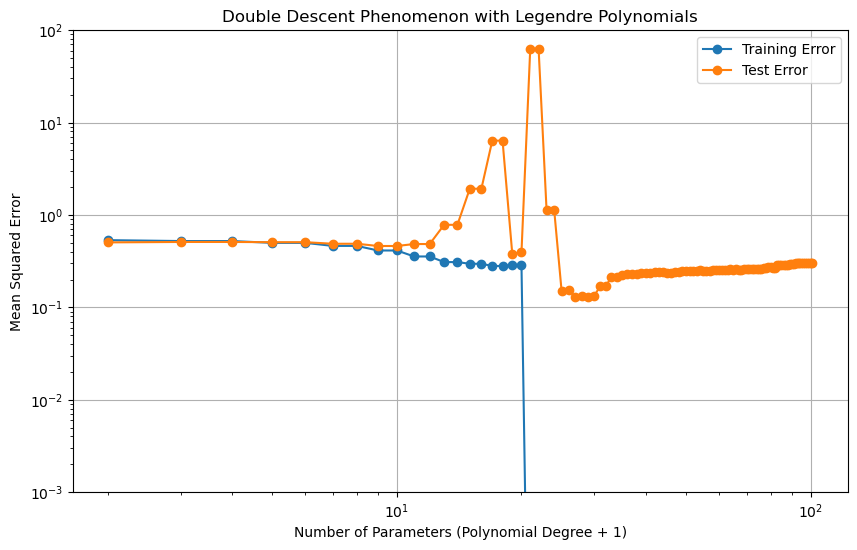

In [8]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import scipy.special

# Generate data
def generate_data(num_points=100, noise_std=0.001):
    x = torch.linspace(-1, 1, num_points).unsqueeze(1)
    y = 2*x + torch.cos(25*x) + noise_std * torch.randn_like(x)
    return x, y

# Normalize data

# Split data into training and testing sets
num_train = 20
num_test = 100

x_train, y_train = generate_data(num_train)
x_test, y_test = generate_data(num_test)


# Generate Legendre polynomial features
def create_legendre_features(x, degree):
    x_np = x.numpy()
    legendre_features = [scipy.special.eval_legendre(i, x_np.flatten()) for i in range(degree + 1)]
    return torch.tensor(np.column_stack(legendre_features), dtype=torch.float32)

# Solve using Moore-Penrose pseudoinverse with regularization
def solve_with_regularized_pseudoinverse(x_train_poly, y_train, x_test_poly, y_test, lambda_reg=1e-2):
    # Compute regularized pseudoinverse
    I = torch.eye(x_train_poly.size(1))
    gram_matrix = x_train_poly.T @ x_train_poly + lambda_reg * I

    # Check conditioning of the gram matrix
    condition_number = torch.linalg.cond(gram_matrix)
    if condition_number > 1e10:
        print(f"Warning: Ill-conditioned matrix at degree {x_train_poly.size(1) - 1}, condition number: {condition_number}")

    pseudoinverse = torch.linalg.pinv(gram_matrix) @ x_train_poly.T
    weights = pseudoinverse @ y_train

    # Compute predictions
    y_train_pred = x_train_poly @ weights
    y_test_pred = x_test_poly @ weights

    # Compute errors
    train_error = ((y_train - y_train_pred)**2).mean().item()
    test_error = ((y_test - y_test_pred)**2).mean().item()

    return train_error, test_error

# Solve using Adam optimizer with regularization
def solve_with_adam(x_train_poly, y_train, x_test_poly, y_test, lambda_reg=1e-8, lr=0.01, epochs=1000):
    model = torch.nn.Linear(x_train_poly.size(1), 1, bias=False)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=lambda_reg)
    criterion = torch.nn.MSELoss()

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        y_pred = model(x_train_poly)
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        y_train_pred = model(x_train_poly)
        y_test_pred = model(x_test_poly)
        train_error = ((y_train - y_train_pred)**2).mean().item()
        test_error = ((y_test - y_test_pred)**2).mean().item()

    return train_error, test_error

# Train and evaluate models with varying degrees
def train_and_evaluate(max_degree, lambda_reg=1e-2, use_adam=False):
    train_errors = []
    test_errors = []
    param_counts = []

    for degree in range(1, max_degree + 1):
        print(f"Training model with Legendre polynomial degree {degree}...")

        # Prepare data with Legendre polynomial features
        x_train_poly = create_legendre_features(x_train, degree)
        x_test_poly = create_legendre_features(x_test, degree)

        if use_adam:
            train_error, test_error = solve_with_adam(
                x_train_poly, y_train, x_test_poly, y_test, lambda_reg=lambda_reg
            )
        else:
            train_error, test_error = solve_with_regularized_pseudoinverse(
                x_train_poly, y_train, x_test_poly, y_test, lambda_reg=lambda_reg
            )

        # Store errors and parameter counts
        train_errors.append(train_error)
        test_errors.append(test_error)
        param_counts.append((degree + 1))  # Number of parameters = degree + 1

        print(f"Degree {degree} completed. Train Error: {train_error:.6f}, Test Error: {test_error:.6f}\n")

    return param_counts, train_errors, test_errors

# Perform experiment
max_degree = 100 # Extend degree range to observe double descent
lambda_reg = 0  # Regularization strength
use_adam = False  # Set to True to use Adam optimizer
param_counts, train_errors, test_errors = train_and_evaluate(max_degree, lambda_reg=lambda_reg, use_adam=use_adam)

# Plot results
plt.figure(figsize=(10, 6))
plt.loglog(param_counts, train_errors, label="Training Error", marker='o')
plt.loglog(param_counts, test_errors, label="Test Error", marker='o')
plt.ylim([1e-3,100])
plt.xlabel("Number of Parameters (Polynomial Degree + 1)")
plt.ylabel("Mean Squared Error")
plt.title("Double Descent Phenomenon with Legendre Polynomials")
plt.legend()
plt.grid(True)
plt.show()
